# 5. Training in Physics

In the last notebook events from the Di-Higgs signal process and some of its background processes were selected which fulfilled a desired signiture consisting of lepton and jet counts and requirements on some physical observables. The selected data was then converted into a vector form which can be used as input by a neural network and saved into files.

In this notebook a neural network will be constructed which is capable of taking the selected data from the last notebook as input and target values for the training will be constructed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep
import os

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import RandomUniform

2022-08-24 16:26:47.378335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-24 16:26:47.378368: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# open the neural network input vectors

nn_input = {}

# 'bgr_Wj'
processes = ['signal', 'bgr_tt', 'bgr_st']

for process in processes:
    nn_input[process] = np.loadtxt('nn_input_' + process + '.txt', delimiter = ' ')
    
    # simplify data structure by transposing
    nn_input[process] = np.transpose(nn_input[process]).tolist()

Not only do we want to understand if the if the event in question is part of the signal or the background, we also want to be able to differentiate the various background processes. Essentially, we are building a *multiclassifier* neural network. This means that the network, instead of returning a binary "signal" or "background" response, returns an output vector of which each element is associated with the probablility of identifying the events as stemming from the various processes. In our case we have 3 processes that have to be distinguished from one another (the background W + jets is not being considered here, since it's sample size is too small to make any meaningful training with it); an exemplary output vector of the shape (0 0 1) would indicate the ideal case of identifying an event as a single top background event.

The process of constructing the neural network is shown in the following two cells and is very much reminiscient of how the exemplary neural network was set up in the third notebook. As to the structure of the network, in total 5 layers will be used where the input layer consists of 15 nodes corresponding to the various physical observables of the selected events, the output layer consists of 3 nodes corresponding to the three processes the events are meant to be classified as. The three hidden layers in between have 512 nodes. They are quite large such that they are capable of picking up on the differentiating nuances in the events. A certain number of hidden layers and their layer sizes directly affects the training duration. Thus the number of layers and layer sizes must be chosen in a way such that the training can be completed in a reasonable time frame.

In [3]:
# define structure of the network

# dimensions of input, hidden and output layers
N0 = len(nn_input['signal'][0])
N1 = 512
N2 = len(processes)

# number of hidden layers
layer_count = 3

# layer structure of the network
layers = [N0]

for l in range(layer_count):
    layers.append(N1)
    
layers.append(N2)

print("Layer structure of the network: ", layers)

Layer structure of the network:  [15, 512, 512, 512, 3]


The activation function of the output layer is chosen to be a *softmax* instead of the sigmoid that is being used everywhere else. That is because the softmax function in normalized in a way, such that the ouput is a number between 0 and 1 and can be read as a probability:

### $(1) \,\,\, \sigma(\vec{z})_{i} = \frac{e^{z_{i}}}{\sum{e^{z_{j}}}}$

In [4]:
# construct the network in keras

net = Sequential()

# set the weights initializer
initializer = RandomUniform(minval = -1, maxval = 1)

# make the first layer with the input shape as an argument
net.add(Dense(layers[1], input_shape = (layers[0],), activation = 'sigmoid', 
              use_bias = True, kernel_initializer = initializer))

# make hidden layers
for i in range(2, len(layers) - 1):
    net.add(Dense(layers[i], activation = 'sigmoid', use_bias = True, kernel_initializer = initializer))

# make output layer
net.add(Dense(layers[-1], activation = 'softmax', use_bias = True, kernel_initializer = initializer))

2022-08-24 16:26:50.632255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-24 16:26:50.632289: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-24 16:26:50.632312: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (batch1375.desy.de): /proc/driver/nvidia/version does not exist
2022-08-24 16:26:50.632546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# compile the network
net.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.SGD(learning_rate = 0.01), metrics = ['categorical_accuracy'])

As the processes from which the exact training events are made are known, it is very simple to generate the target output which will be used for verification during training. As discussed above the target vectors have three elements (as many elements as processes that are meant to be differentiated) which are 0 except one of them which is 1 corresponding to the process that the event in question originated from. There are as many target vectors being made as there are input vectors and depending on the process they are of the form (1 0 0), (0 1 0) or (0 0 1). Similar to the input vectors the target vectors are stored in a dictionary for the respective processes.

In [6]:
# making of the target output

# target dictionary
nn_target = {}

training_duration = 0

# make target data for a particular process
def make_target(p, proc):
    
    vectors = []
    
    for i in range(len(nn_input[proc])):
    
        v = np.zeros(len(processes))
        v[p] = 1

        vectors.append(v)
    
    return vectors, len(vectors)

In [7]:
# make target data for all processes
for count, process in enumerate(processes):
    nn_target[process] = make_target(count, process)[0]
    training_duration += make_target(count, process)[1]

print(nn_target['signal'][10])

[1. 0. 0.]


In [8]:
# number of epochs
epochs = 1000

# cost
costs = np.empty(epochs)
metrics_1 = np.empty(epochs)

In [9]:
# put input and target data all in one array

nn_input_training = []
nn_target_training = []

nn_input_validation = []
nn_target_validation = []

for process in processes:
    nn_input_training = nn_input_training + nn_input[process][:3000]
    nn_target_training = nn_target_training + nn_target[process][:3000]
    
    nn_input_validation = nn_input_validation + nn_input[process][3000:4344]
    nn_target_validation = nn_target_validation + nn_target[process][3000:4344]

nn_input_training = np.array(nn_input_training)
nn_target_training = np.array(nn_target_training)

nn_input_validation = np.array(nn_input_validation)
nn_target_validation = np.array(nn_target_validation)
    
print(np.shape(nn_input_training))
print(np.shape(nn_target_training))
print(np.shape(nn_input_validation))
print(np.shape(nn_target_validation))

(9000, 15)
(9000, 3)
(4032, 15)
(4032, 3)


In [10]:
history = net.fit(x = nn_input_training, y = nn_target_training, epochs = epochs, 
                  validation_data = (nn_input_validation, nn_target_validation), shuffle = True, verbose = 0)

In [11]:
for i in history.history:
    print(i)
    
# print(history.history['loss'])

loss
categorical_accuracy
val_loss
val_categorical_accuracy


Lowest loss value:  1.2380887269973755


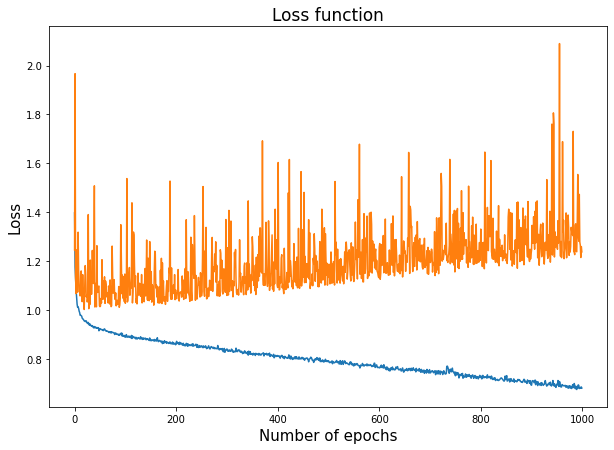

In [12]:
plt.figure(figsize = (10, 7), facecolor = 'white')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss function', fontsize = 17)
plt.xlabel('Number of epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)

print('Lowest loss value: ', history.history['val_loss'][-1])

Highest accuracy value:  0.4774305522441864


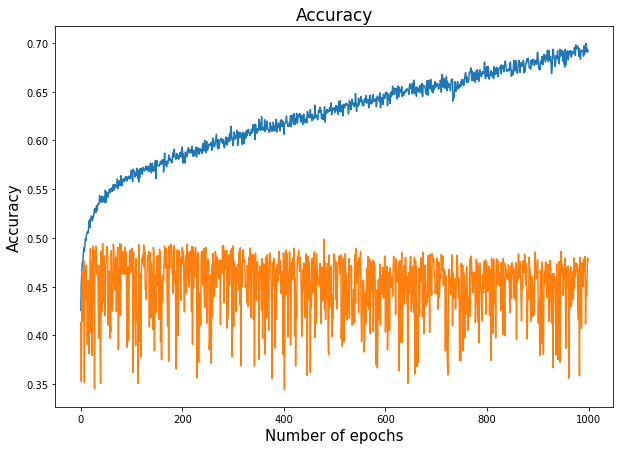

In [13]:
plt.figure(figsize = (10, 7), facecolor = 'white')

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

plt.title('Accuracy', fontsize = 17)
plt.xlabel('Number of epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)

print('Highest accuracy value: ', history.history['val_categorical_accuracy'][-1])

In [14]:
predictions = {}

for process in processes:
    predictions[process] = net.predict_on_batch(np.array(nn_input[process][3000:4344]))
    
    mean_classifier = []
    
    for i in range(3):
        mean_classifier.append(np.mean(predictions[process][:, i]))
        
    print('Mean classifier of ' + process + ' process', mean_classifier)
        

# probe = net.predict_on_batch(np.array([nn_input['signal'][100]]))

Mean classifier of signal process [0.5890549, 0.23179513, 0.17914999]
Mean classifier of bgr_tt process [0.28018022, 0.44250697, 0.2773128]
Mean classifier of bgr_st process [0.3114456, 0.39086273, 0.29769167]


# BACKUP CELLS

In [15]:
# permutate for training

p = np.random.permutation(len(nn_input_training))

nn_input_training = nn_input_training[p]
nn_target_training = nn_target_training[p]

In [16]:
# train network

for i in range(epochs):
    costs[i] = net.train_on_batch(nn_input_training, nn_target_training)[0]
    metrics_1[i] = net.train_on_batch(nn_input_training, nn_target_training)[1]